<a href="https://colab.research.google.com/github/AntoninoParisi/HMM_crypto_forecasting/blob/main/progetto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning - Cryptocurrency forecasting through HMM models

In [1]:
!pip install hmmlearn



     |████████████████████████████████| 374 kB 45.6 MB/s 


In [2]:
import numpy as np
import scipy
import sklearn
from hmmlearn import hmm
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.linear_model import LinearRegression, SGDRegressor
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
from scipy.stats import linregress




In [3]:
# data analisys #



## Dataset ##
dataset = []
days = 60; # number of prediction days
months_for_training = 6



# importing data from csv
with open('/content/coin_Ethereum.csv') as f:
  ds = csv.reader(f)
  next(ds,None) #skip line of column labels
  for row in ds:
      dataset.append(row)



dataset = np.array(dataset)
dataset = dataset[::-1]
print('initial shape of daset: ',dataset.shape) # check of the dataset shape




dataset = dataset[:,[4,5,6,7]] # keeping only high,low,open,close cols






dataset = dataset.astype(np.float)



# features 

# next day price
test_data_full = dataset[:days,:] # used to compute the inverse formula of closing price using features
utils_data_full = dataset[1,:]

dataset = np.delete(dataset,range(days),0) # deleting n days of prediction



dataset = dataset[::-1]




fracChange = (np.divide(dataset[:,3],dataset[:,2]) - 1) # feature 1: close - open / open 
fracHigh   = (np.divide(dataset[:,0],dataset[:,2]) - 1) # feature 2: high - open / open
fracLow    = (1 - np.divide(dataset[:,1],dataset[:,2])) # feature 3: open - low / open




dataset = np.column_stack([fracChange, fracHigh, fracLow])


dataset = dataset[:months_for_training*30,:]

# training on features and testing on closing price (see dimension of test dataset)
print('shape of training: ',dataset.shape) # check of the dataset shape
print('shape of test set: ',test_data_full.shape) # check of the dataset shape



initial shape of daset:  (2160, 10)
shape of training:  (180, 3)
shape of test set:  (60, 4)


# GMMHMM 

In [4]:
## Model inizialization ##
np.random.seed(432)

model = hmm.GMMHMM(
     n_components=4,
     n_mix=1,
     n_iter=4000,
     tol=0.01,
     verbose=True, 
     algorithm='viterbi',
     covariance_type='spherical')

## Model paramaters definition ##


# all these parameters are overwritten with training, useless to set it before
# we leave it here just for the sake of completeness

#prob = np.random.rand(1,4)
#prob = prob/prob.sum(axis=1)[:,None] #row wise sum is unitary

#model.startprob_ = prob

#model.transmat_ = np.array([[0.7, 0.2, 0.1],[0.3, 0.5, 0.2],[0.3, 0.3, 0.4]])

#model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#model.covars_ = np.tile(np.identity(2), (3, 1, 1))




## fitting the model ##

model.fit(dataset.reshape(-1,1))







         1         273.9715             +nan
         2         630.6885        +356.7170
         3         683.2786         +52.5900
         4         705.6272         +22.3486
         5         715.7676         +10.1404
         6         721.0424          +5.2748
         7         724.9559          +3.9134
         8         728.3971          +3.4413
         9         731.6446          +3.2474
        10         734.9871          +3.3425
        11         738.7959          +3.8088
        12         743.4372          +4.6413
        13         748.9638          +5.5266
        14         754.6636          +5.6998
        15         759.3186          +4.6549
        16         762.3280          +3.0094
        17         764.0730          +1.7449
        18         765.1793          +1.1064
        19         766.0141          +0.8348
        20         766.7181          +0.7040
        21         767.3417          +0.6236
        22         767.9120          +0.5702
        23

GMMHMM(algorithm='viterbi', covariance_type='spherical',
       covars_prior=array([[-1.5],
       [-1.5],
       [-1.5],
       [-1.5]]),
       covars_weight=array([[0.],
       [0.],
       [0.],
       [0.]]),
       init_params='stmcw',
       means_prior=array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.],
       [0.]]),
       min_covar=0.001, n_components=4, n_iter=4000, n_mix=1, params='stmcw',
       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=True,
       weights_prior=array([[1.],
       [1.],
       [1.],
       [1.]]))

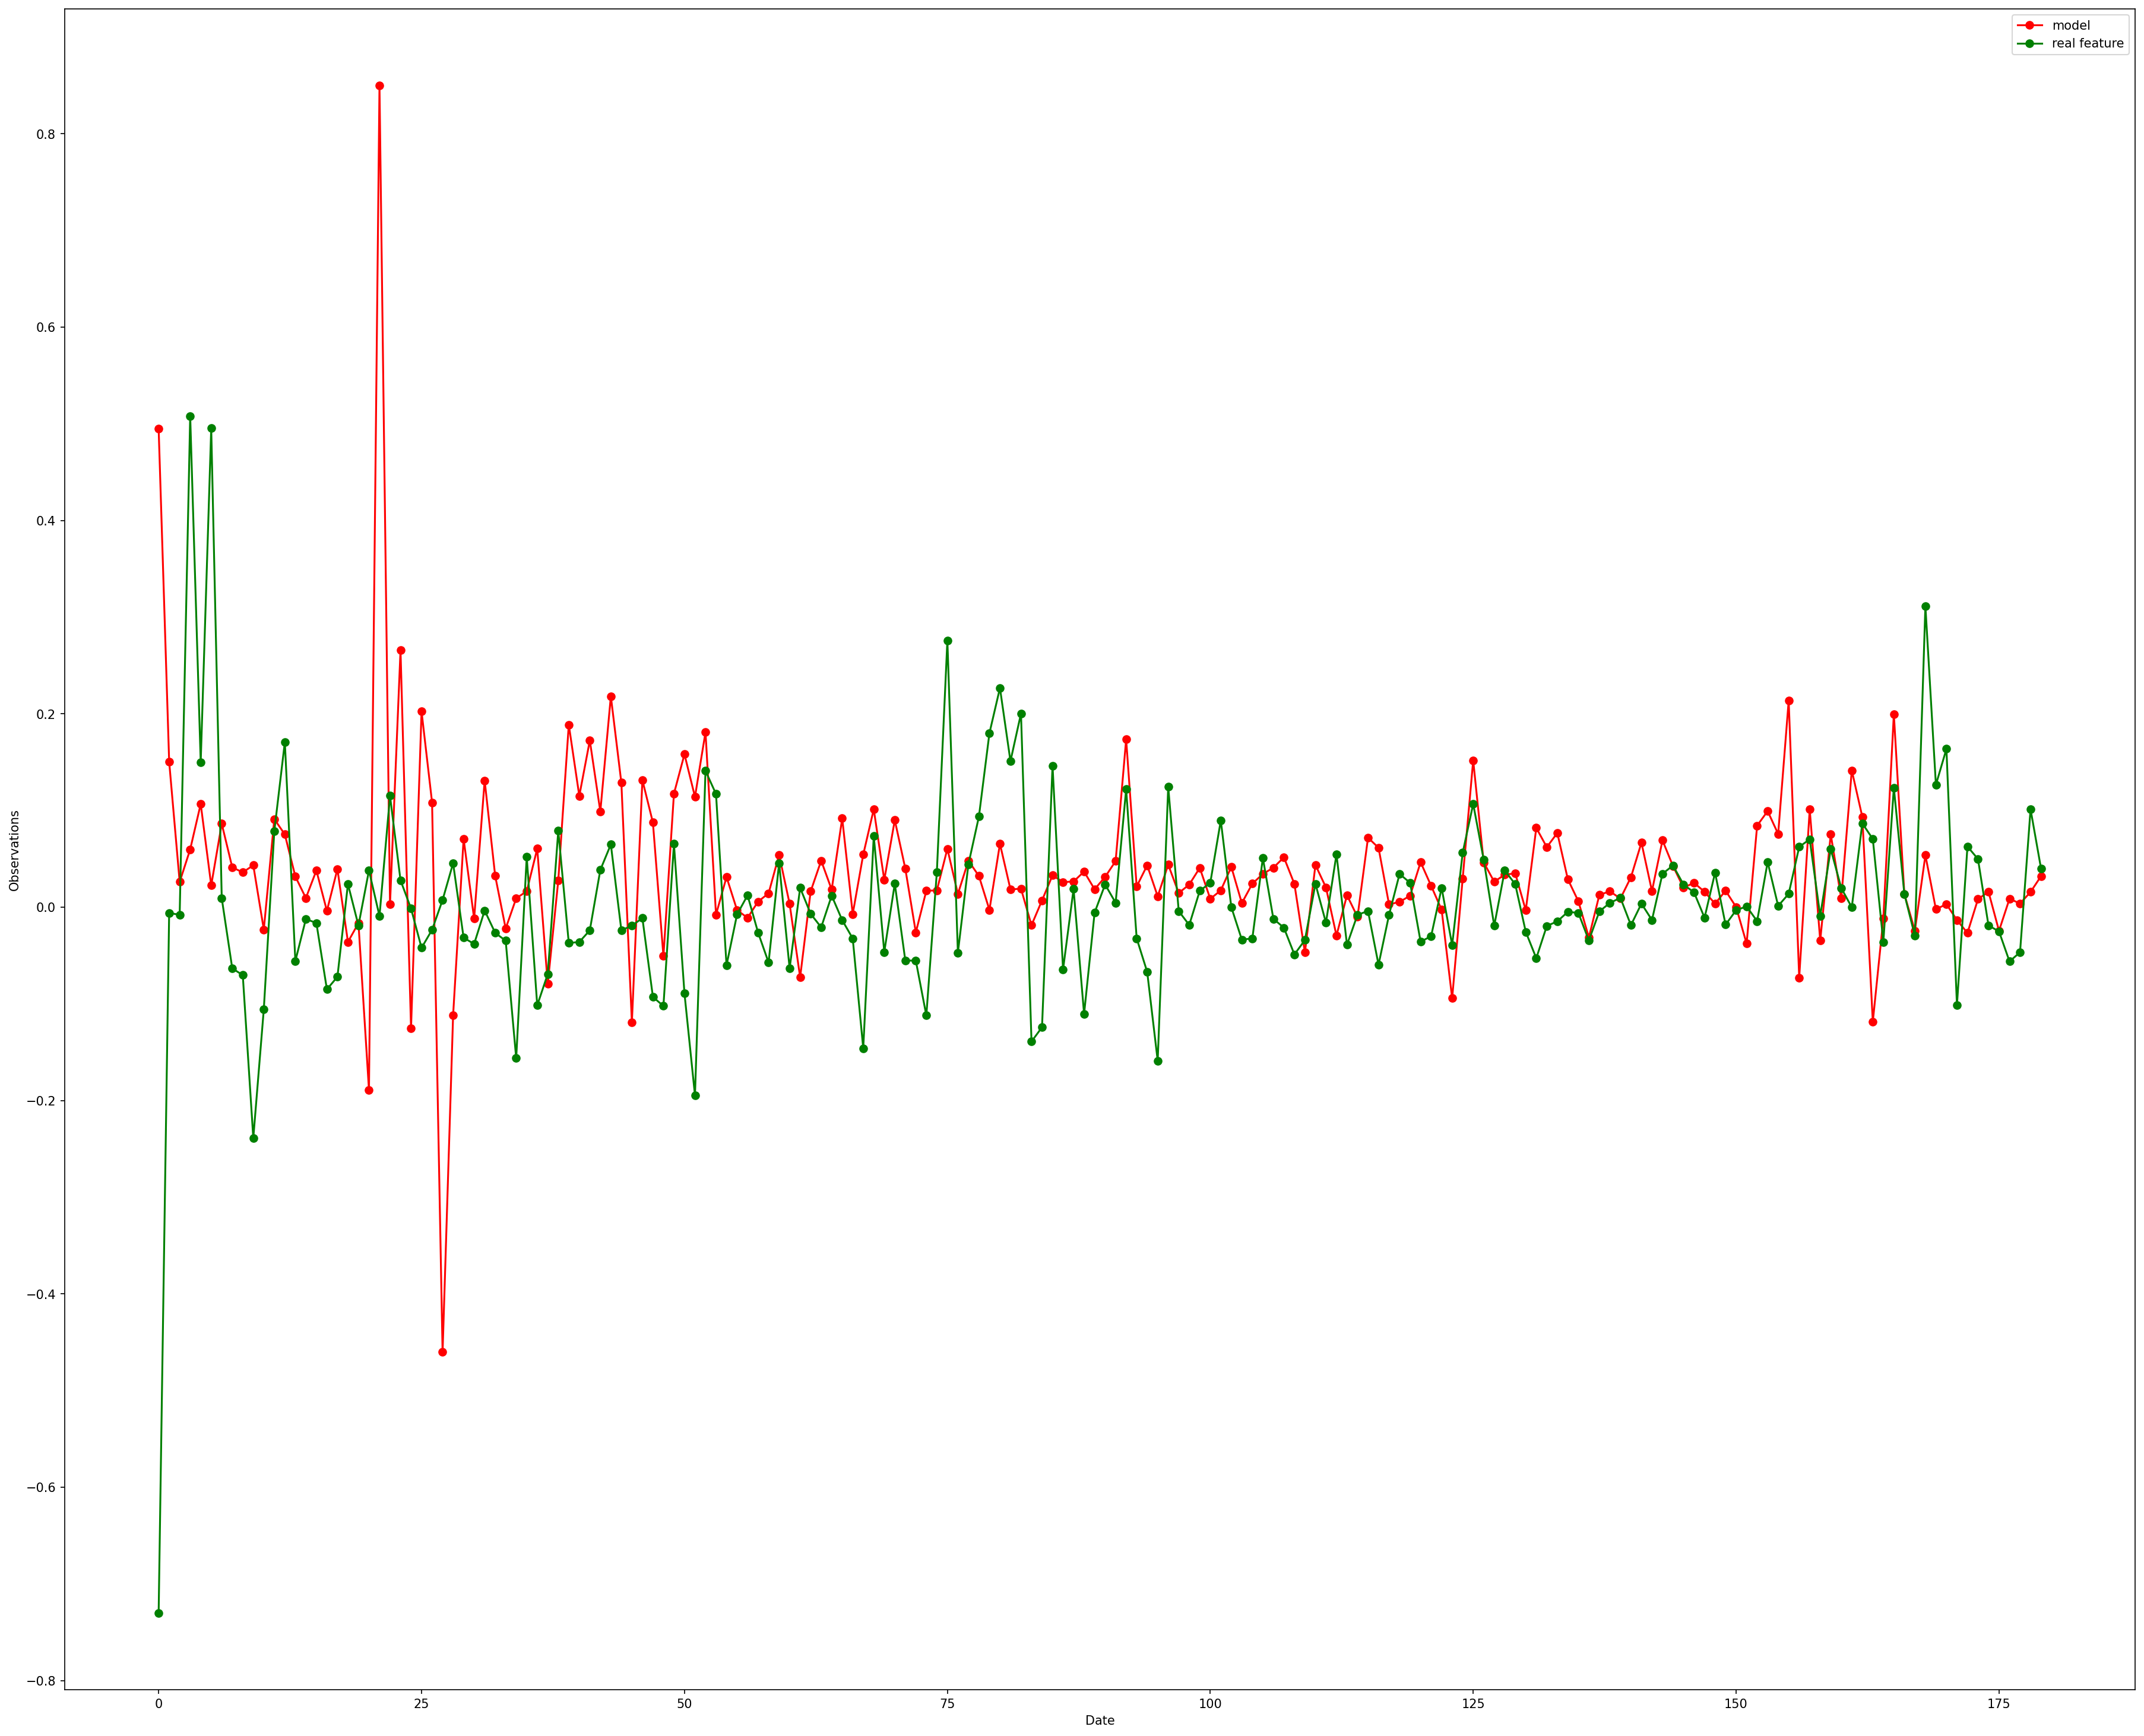

In [5]:
# plotting the evolution of n samples starting from casual initial state #

n_samples = len(dataset)
samples,_ = model.sample(n_samples)



figure(figsize=(30, 25), dpi=150)


# comparison between the syntetic data of our model and real data starting from a casual state
plt.plot(np.arange(n_samples),samples[:,0],color='red', marker='o',label='model')
plt.plot(np.arange(len(dataset)),dataset[:,0],color='green', marker='o',label='real feature')
plt.xlabel('Date')
plt.ylabel('Observations')
plt.legend()
plt.show()







In [6]:
# creating observation set to find out the best sequence of features for next X days

# those ranges are based on dataset observations
predFracChange = np.linspace(-0.1,0.1, num=50)
predFracChange = predFracChange[::-1]
predFracHigh   = np.linspace(0,0.1, num=50)
predFracHigh = predFracHigh[::-1]
predFracLow    = np.linspace(0,0.1, num=50)
predFracLow = predFracLow[::-1]


observations = []
for i in predFracChange:
    for j in predFracHigh:
        for k in predFracLow:
            observations.append([i,j,k])

np.random.shuffle(observations) 


tmp = []
observations_seq  = []



observations_number = 10000;

for j in range(observations_number):
  for i in range(days):
    row = np.random.randint(0,high=len(observations))# extraction of samples in random way
    if(len(tmp)>0):
        tmp = np.vstack([tmp, observations[row]])
    else:
        tmp = observations[row]
  observations_seq.append(tmp)
  tmp = []








In [7]:

observationSeq = dataset[-5:] # days of real dataset observations to drive the prediction
observations_seq = np.array(observations_seq)

seq = observationSeq
best = []
score = -np.inf

# looking for the best sequence starting with the real data sequence
for i in observations_seq:
    test_seq = np.vstack([seq, i])
    s = model.score(test_seq.reshape(-1,1)) # max likelihood of this sequence
    if(s > score):
        best = i
        score = s
        print('best actual score : ',score)



best actual score :  254.13922757953094
best actual score :  255.27968696801105
best actual score :  264.3954977583694
best actual score :  268.15365342721634
best actual score :  269.7021779867443
best actual score :  280.40862015431225
best actual score :  286.45331666408055
best actual score :  296.7649520321587
best actual score :  299.5285932912978
best actual score :  305.137182386442
best actual score :  308.0293228830365
best actual score :  318.64448529030267


In [8]:
print('Sequence found for the next ',days,' days')
print(best)


Sequence found for the next  60  days
[[-0.05510204  0.06734694  0.05510204]
 [ 0.03877551  0.07142857  0.05918367]
 [-0.05510204  0.0244898   0.01020408]
 [ 0.03877551  0.00408163  0.00204082]
 [-0.05102041  0.0244898   0.09183673]
 [ 0.03061224  0.01020408  0.07755102]
 [ 0.08367347  0.00408163  0.        ]
 [ 0.01020408  0.04897959  0.03469388]
 [ 0.06326531  0.0244898   0.07346939]
 [ 0.04285714  0.02857143  0.09183673]
 [ 0.0755102   0.04285714  0.0755102 ]
 [ 0.0755102   0.01632653  0.09387755]
 [ 0.0755102   0.07346939  0.01428571]
 [-0.06734694  0.00816327  0.06122449]
 [ 0.0877551   0.02040816  0.03061224]
 [ 0.05918367  0.05102041  0.02653061]
 [ 0.03877551  0.06122449  0.1       ]
 [ 0.01428571  0.00204082  0.04285714]
 [ 0.03877551  0.0244898   0.0122449 ]
 [ 0.0877551   0.06326531  0.07142857]
 [ 0.09591837  0.03265306  0.07959184]
 [ 0.02244898  0.09387755  0.04285714]
 [ 0.05918367  0.03469388  0.00612245]
 [ 0.03469388  0.05102041  0.04081633]
 [ 0.03061224  0.0877551  

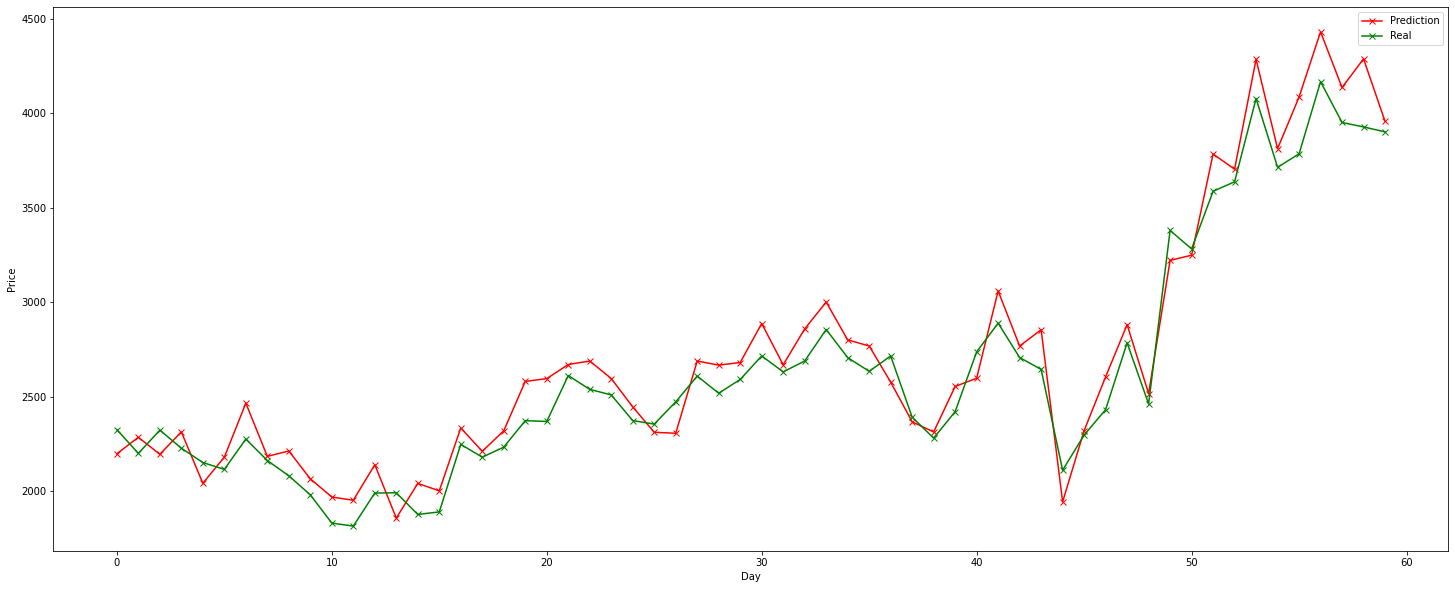

In [9]:
# inverse formula to forecast the next day feature

real_closing_price = test_data_full[:,3]


set_closing_price = []
index = 0
for i in best:
  set_closing_price.append(test_data_full[index][3]*(i[0]+1)) # inverse formula 
  index = index+1



set_closing_price = np.array(set_closing_price)

plt.figure(figsize=[25,10])
plt.plot(np.arange(len(set_closing_price)),set_closing_price,'r-x')
plt.plot(np.arange(len(set_closing_price)),real_closing_price,'g-x')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Prediction','Real'])





In [10]:
check_result = np.zeros([len(set_closing_price),1])


# our perfomance index  mean((forecast-real)/real)
for i in range(len(set_closing_price)):
    check_result[i] = (set_closing_price[i] - real_closing_price[i])/real_closing_price[i]

error = np.mean(check_result)

print('Our performance index in ',days,' days: ',np.round(error,decimals=3))
print('R2 : ',r2_score(real_closing_price,set_closing_price)) # 1 is best value, can be negative
print('Explained variance : ',explained_variance_score(real_closing_price,set_closing_price)) # 1 is best value



Our performance index in  60  days:  0.029
R2 :  0.9444123667076703
Explained variance :  0.9616328085996703




#Linear Regression


In [11]:
# transformation of previous dataset in pandas dataframe

df = pd.DataFrame(dataset);

print(df.head())

ds = pd.read_csv('coin_Ethereum.csv')

ds_f = np.array(ds[["High","Low","Open","Close"]])

close = ds["Close"]

close_train = np.array(close[:2100])

close_test = np.array(close[::-1])
close_test = np.array(close_test[:60])
close_test = close_test[::-1]




open = np.array(ds['Open'])
open = open[::-1]
open = np.array(open[:60])
open = open[::-1]

ds_f = ds_f[::-1]
ds_f = ds_f[:60]
ds_f = ds_f[::-1]

f1 = (np.divide(ds_f[:,3],ds_f[:,2]) - 1) # feature 1: close - open / open 
f2   = (np.divide(ds_f[:,0],ds_f[:,2]) - 1) # feature 2: high - open / open
f3    = (1 - np.divide(ds_f[:,1],ds_f[:,2])) # feature 3: open - low / open




test_set = np.column_stack([f1, f2, f3])



          0         1         2
0 -0.730354  0.001808  0.744171
1 -0.006003  0.245950  0.108966
2 -0.007761  0.022220  0.108465
3  0.508091  0.597840  0.063343
4  0.149884  0.218361  0.165423


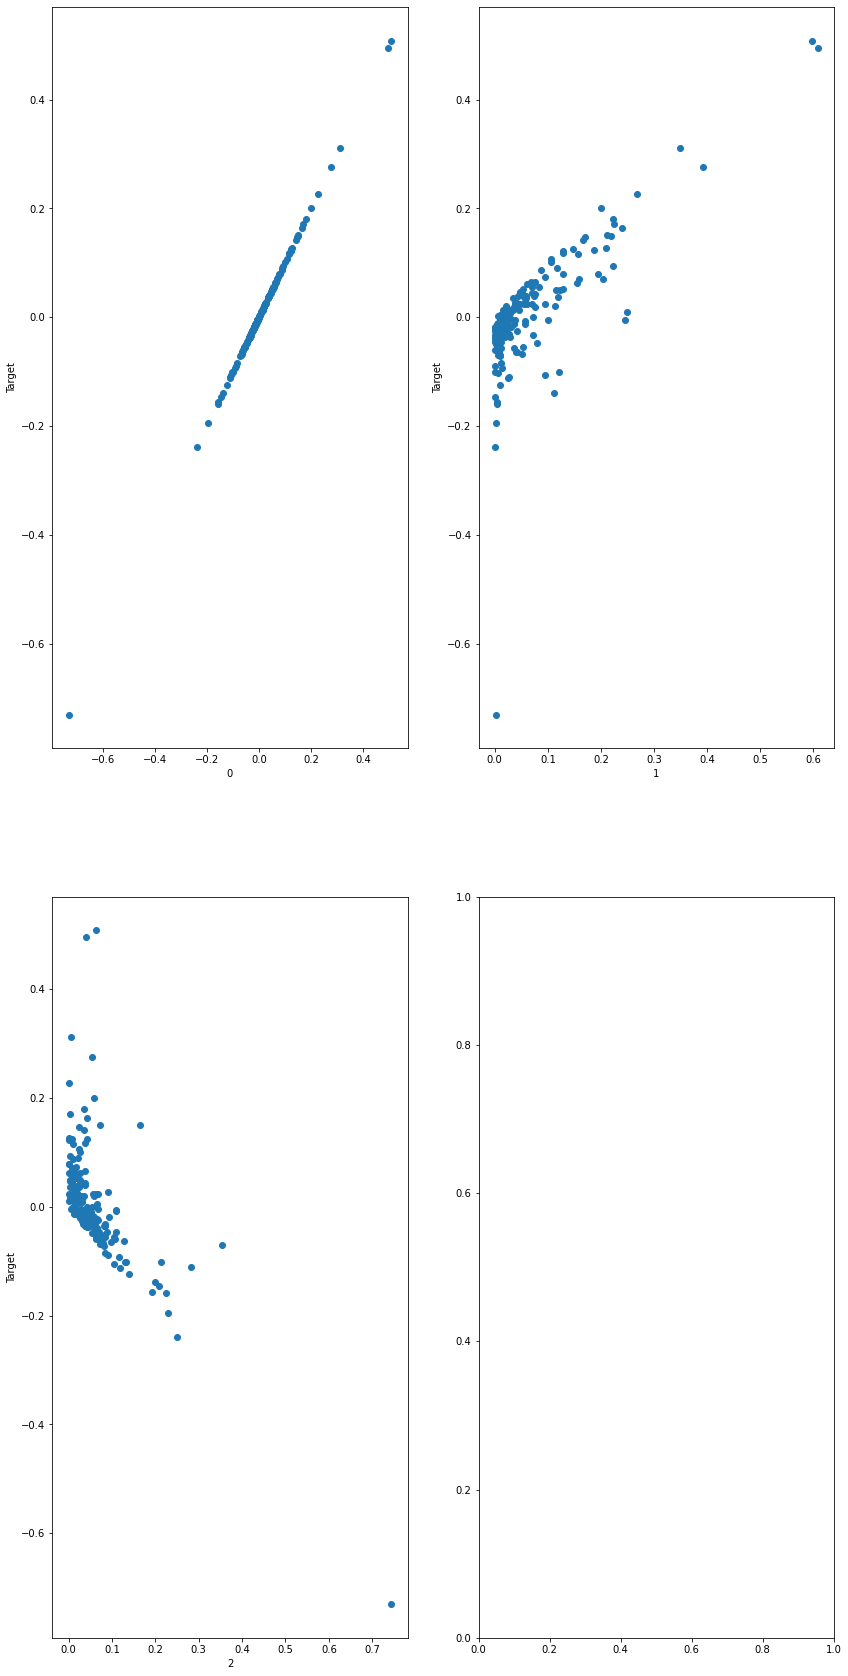

In [12]:
# dataset features compared to feature 1

# comparison of feature 1 in realtion of the other 2 features
fig, axs = plt.subplots(2, 2, figsize=(14, 30))
for index, feature in enumerate(df):
    subplot_idx = int(index / 2)
    if index % 2 == 0:
        axs[subplot_idx, 0].scatter(x=df.loc[:, feature], y=df.loc[:, 0])
        axs[subplot_idx, 0].set_xlabel(feature)
        axs[subplot_idx, 0].set_ylabel("Target")
    else:
        axs[subplot_idx, 1].scatter(x=df.loc[:, feature], y=df.loc[:, 0])
        axs[subplot_idx, 1].set_xlabel(feature)
        axs[subplot_idx, 1].set_ylabel("Target")

plt.show()

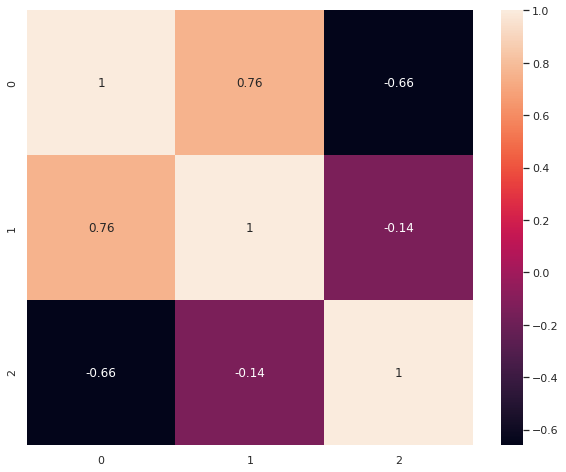

In [13]:
correlation_matrix = df.corr().round(2)
annot = True
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=correlation_matrix, annot=annot)
plt.show()

In [14]:
# normalizing dataset

scaler = MinMaxScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

X_all = scaled_data
X_sm = scaled_data[:, [0,2]]
y = scaled_data[:, 0] 


scaler2 = MinMaxScaler()


scaler2.fit(test_set)

scaled_data2 = scaler2.transform(test_set)
test_all = scaled_data2;
y_test = test_set[:,0]

# Print out the shapes of the newly created variables as verification
print('Scaled data (full dataset) : ',X_all.shape, '\nScaled data (choosen features) : ',X_sm.shape, '\nScaled reference feature: ',y.shape)
print('test set ',(test_all.shape))


Scaled data (full dataset) :  (180, 3) 
Scaled data (choosen features) :  (180, 2) 
Scaled reference feature:  (180,)
test set  (60, 3)


Projection matrix: [ 1.00000000e+00  3.85524945e-14 -3.66096042e-14]


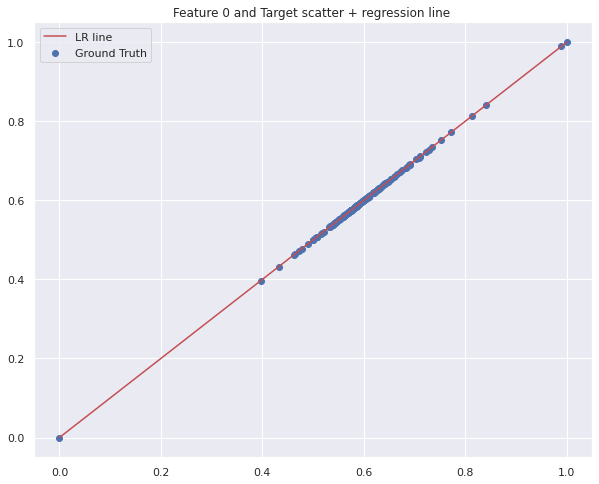

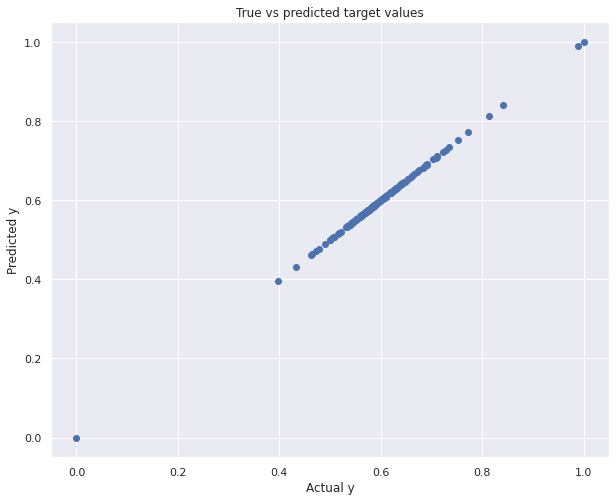

R2 :  0.8729183291183569
Explained variance :  0.8729233606315681
Idx :  0.0
R2 train:  1.0
Explained variance train:  1.0
Idx train:  0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


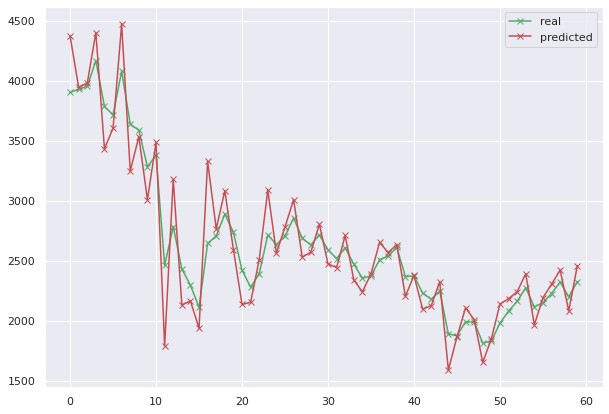

In [16]:
bias_ones = np.ones((X_sm.shape[0], 1))  # add bias terms
X = np.append(X_sm, bias_ones, axis=1)
pseudo_inverse = np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T)
lse = np.dot(pseudo_inverse, y)
print("Projection matrix:", lse)

# LR line
gradient, intercept, r_value, p_value, std_err = linregress(X[:,0],y) #x and y are arrays or lists.


plt.figure()
mn=0
mx=1
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept

# Use the least squares solution to make predictions
y_pred = np.matmul(X, lse)


y_60_days_pred = np.matmul(test_set, lse)



# Plot results
plt.scatter(X[:, 0], y, label="Ground Truth")
plt.plot(x1,y1,'-r',label='LR line')
plt.title('Feature 0 and Target scatter + regression line ')
plt.legend()
plt.show()

plt.scatter(y, y_pred)
plt.title('True vs predicted target values')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()




predicted_set_closing_price_LR = []



index=0
for i in y_60_days_pred:
  predicted_set_closing_price_LR.append(close_test[index]*(i+1)) # inverse formula 
  index = index+1





idx = np.round((y_60_days_pred-y_test)/y_test,decimals=10)
idx[idx == np.inf] = 0
idx[idx == -np.inf] = 0

idx_train = np.round((y_pred-y)/y,decimals=10)
idx_train[idx_train == np.inf] = 0
idx_train[idx_train == -np.inf] = 0



print('R2 : ',r2_score(close_test, predicted_set_closing_price_LR)) # 1 is best value, can be negative
print('Explained variance : ',explained_variance_score(close_test, predicted_set_closing_price_LR)) # 1 is best value
print('Idx : ',np.mean(idx)) # 0 is best value

print('R2 train: ',r2_score(y, y_pred)) # 1 is best value, can be negative
print('Explained variance train: ',explained_variance_score(y, y_pred)) # 1 is best value
print('Idx train: ',np.mean(idx_train)) # 0 is best value

plt.figure(figsize=[10,7])
plt.plot(np.arange(len(close_test)),close_test,'g-x',label='real')
plt.plot(np.arange(len(predicted_set_closing_price_LR)),predicted_set_closing_price_LR,'r-x',label='predicted')
plt.legend()


Iteration 0/100, Loss: 0.02186658970219955
Iteration 20/100, Loss: 0.004890405677453095
Iteration 40/100, Loss: 0.004467611933705594
Iteration 60/100, Loss: 0.004133119965281905
Iteration 80/100, Loss: 0.0038535101667623844


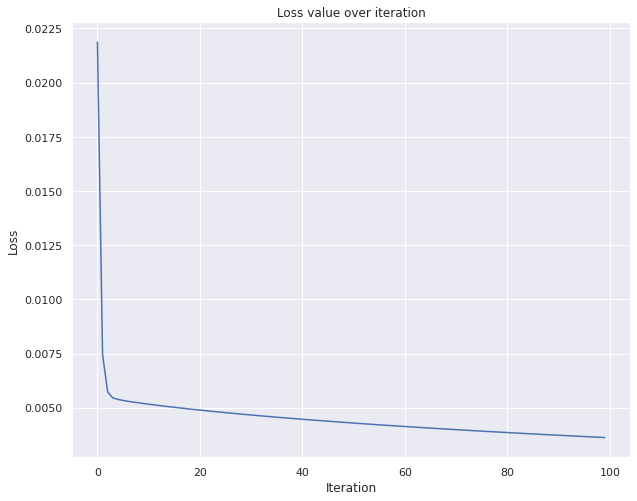

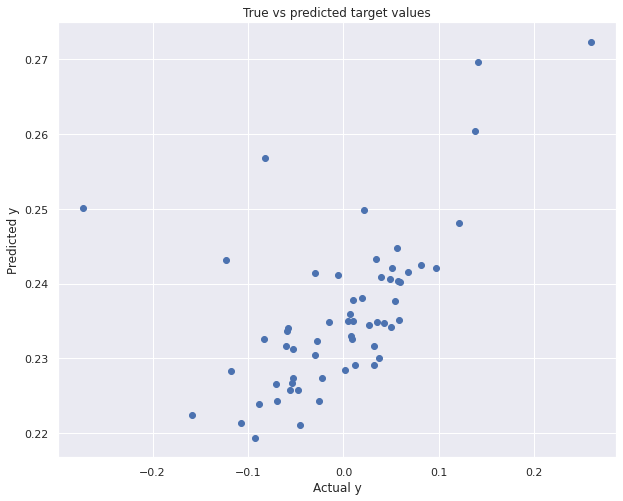

R2 :  -0.10872933235577786
Explained variance :  0.9410949661722611
Idx :  3.89181355388


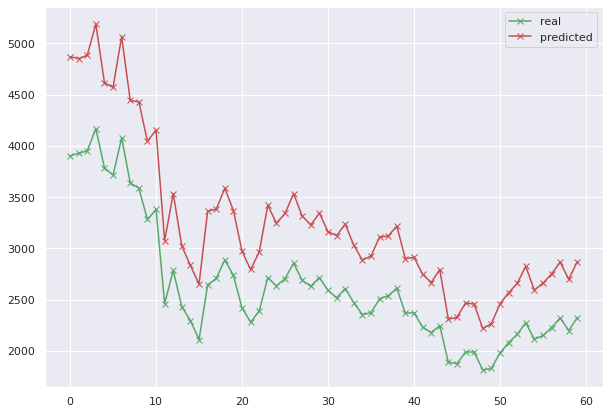

In [17]:
n_iter = 100
losses = []
model = SGDRegressor()
for iter in range(n_iter):
    model.partial_fit(X, y)
    pred = model.predict(X)
    loss = mean_squared_error(y, pred)
    losses.append(loss)
    if iter % 20 == 0:
      print("Iteration {}/{}, Loss: {}".format(iter, n_iter, loss))

# Plot the loss over time/iterations and the predictions vs the ground truth values, just as above.
# Finally print out the MSE.
plt.plot(list(range(n_iter)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss value over iteration")
plt.show()

y_pred_sksgd = model.predict(test_set)
plt.scatter(y_test, y_pred_sksgd)
plt.title('True vs predicted target values')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()

predicted_set_closing_price_LR = []



index=0
for i in y_pred_sksgd:
  predicted_set_closing_price_LR.append(close_test[index]*(i+1)) # inverse formula 
  index = index+1




idx = np.round((y_pred_sksgd-y_test)/y_test,decimals=10)
idx[idx == np.inf] = 0
idx[idx == -np.inf] = 0



print('R2 : ',r2_score(close_test, predicted_set_closing_price_LR)) # 1 is best value, can be negative
print('Explained variance : ',explained_variance_score(close_test, predicted_set_closing_price_LR)) # 1 is best value
print('Idx : ',np.mean(idx)) # 0 is best value


plt.figure(figsize=[10,7])
plt.plot(np.arange(len(close_test)),close_test,'g-x',label='real')
plt.plot(np.arange(len(predicted_set_closing_price_LR)),predicted_set_closing_price_LR,'r-x',label='predicted')
plt.legend()

In [18]:
lr_all, lr_sm = LinearRegression().fit(X_all, y), LinearRegression().fit(X_sm, y)
y_pred_all, y_pred_sm = lr_all.predict(X_all), lr_sm.predict(X_sm)
loss_all, loss_sm = mean_squared_error(y, y_pred_all), mean_squared_error(y, y_pred_sm)

print("Model performances: ")
print("--------------------------------------")
print('R2 (lse): ',r2_score(y_test, y_60_days_pred)) # 1 is best value, can be negative
print('Explained variance (lse): ',explained_variance_score(y_test, y_60_days_pred)) # 1 is best value
print('R2 (grad.desc.): ',r2_score(y_test, y_pred_sksgd)) # 1 is best value, can be negative
print('Explained variance (grad.desc.): ',explained_variance_score(y_test, y_pred_sksgd)) # 1 is best value

Model performances: 
--------------------------------------
R2 (lse):  1.0
Explained variance (lse):  1.0
R2 (grad.desc.):  -8.776198068070743
Explained variance (grad.desc.):  0.1301289457759185


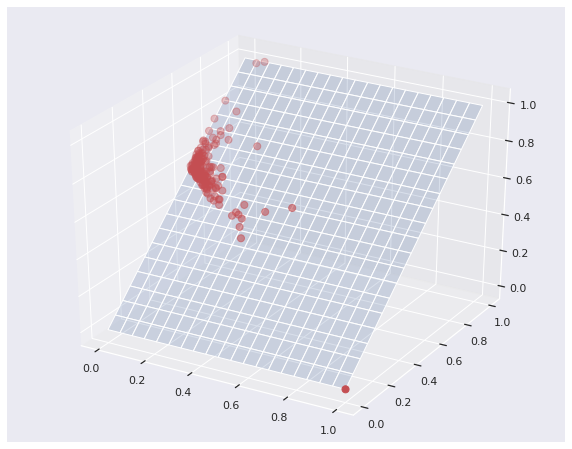

In [19]:
# create x,y,z data and the needed coefficients for the 3d plot 
x = X_sm[:,1]
y = X_sm[:,0]
z = y_pred_sm
data = np.c_[x,y,z]
lr_coeff = lr_sm.coef_
lr_bias = lr_sm.intercept_

# Create X, Y data to predict

mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
XX,YY = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))

# calculate prediction
Z = lr_coeff[1]*XX + lr_coeff[0]*YY + lr_bias

# plot the surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.show()